In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.interpolate as spint

print(np.linalg.norm([1,1,1]))
sample = math.pi*np.array([0,1,2,3,4,5,6,7,8,9])
print(sample)
sample = np.delete(sample, [1,4,6,8])
print(sample)

#max_point_quadratic(1,1,3,2.334,4,2)

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.interpolate as spint
#from scipy.optimize import curve_fit
#from scipy.interpolate import interp1d

def larmor_radius(KE, B, charge_mass_ratio = 9.58e7, charge_in_e = 1, theta_z = 0):
        #everything is in SI units, except for charge_in_e
        c = 3e8
        q = (1.6e-19)*charge_in_e
        m = q/charge_mass_ratio
        E = KE+m*9e16
        p = (math.cos(theta_z))*(1/c)*np.sqrt((E**2)-((m**2)*(c**4)))
        R = p/(q*B)
        return R

def max_point_quadratic(x0, y0, x1, y1, x2, y2):
    d01 = x0 - x1
    d10 = -d01
    d02 = x0 - x2
    d20 = -d02
    d12 = x1 - x2
    d21 = -d12
    A = y0/(d01*d02)
    B = y1/(d10*d12)
    C = y2/(d20*d21)
    x_value = (A*(x1+x2)+B*(x0+x2)+C*(x0+x1))/(2*(A+B+C))
    return x_value

def B_current_segment(I = 1, Ihat = np.array([0,0,1]), dl = 1, r_I = np.array([0,1,0]), x = 1 , y = 1, z = 1):
    mu = 1e-7
    r_vector = np.array([x,y,z])-r_I
    r = np.linalg.norm(r_vector)
    rhat = (1/r)*r_vector
    dl_vector = 0.5*dl*Ihat
    delta_rplus = r_vector - dl_vector
    delta_rminus = r_vector + dl_vector
    dist_rplus = np.linalg.norm(delta_rplus)
    dist_rminus = np.linalg.norm(delta_rminus)
    dist_par_plus = np.dot(delta_rplus,Ihat)
    dist_par_minus = np.dot(delta_rminus,Ihat)
    sines = -(1/dist_rplus)*dist_par_plus + (1/dist_rminus)*dist_par_minus
    I_1 = (np.dot(Ihat,delta_rplus))*Ihat
    R_vector = delta_rplus - I_1
    R = np.linalg.norm(R_vector)
    B = (mu*I/R)*sines*np.cross(Ihat,rhat)
    Bx = B[0]
    By = B[1]
    Bz = B[2]
    return Bx, By, Bz

def B_current_loop(I = 1, N = 8, r = 1, x = 0, y = 0, z = 0, x_center = 0, axis_vector = np.array([1,0,0])):
    deltatheta = 2*math.pi/N
    R = 0.35*r+0.65*r/math.cos(0.5*deltatheta)
    dl = 2*R*math.sin(0.5*deltatheta)
    Bx = 0
    By = 0
    Bz = 0
    for n in range(N):
        r_I = R*math.cos(0.5*deltatheta)*np.array([0,math.cos(n*deltatheta),math.sin(n*deltatheta)])+np.array([x_center,0,0])
        Ihat = np.array([0,-math.sin(n*deltatheta),math.cos(n*deltatheta)])
        B_nx, B_ny, B_nz = B_current_segment(I, Ihat, dl, r_I, x, y, z)
        Bx = Bx + B_nx
        By = By + B_ny
        Bz = Bz + B_nz
    return Bx, By, Bz

def B_current_sheet(I, N, length, width, x, y, z, axis_vector = np.array([1,0,0])):
    return

class MagSpec:
    def __init__(
            self,
            B_data = np.array([1]),
            B_axes = np.array([0]),
            delta_d = 0.00025,
            charge_mass_ratio = 9.58e7,
            charge_in_e = 1,
            gapx = 0.0127,
            gapy = 0.003302,
            plate = 'curved',
            IP_radius = 0.14102,
            IP_center = np.array([0.0450215,-0.12394]),
            x_max = 1,
            x_min = -1,
            y_max = 1,
            y_min = -1,
            dynamic_step = 1,
            fine_adjustment = 8):
        
        #default value for step size
        self.delta_d = delta_d
        #change-to-mass ratio is set a default for protons
        self.charge_mass_ratio = charge_mass_ratio
        self.charge_in_e = charge_in_e
        self.charge = (1.6e-19)*self.charge_in_e
        #these variables are for any gap between the slit and the region where the IPs are
        #gapx is the distance between the slit and the IP region
        #gapy is the width of that region
        self.gapx = gapx
        self.gapy = gapy
        #the geometry of your plate
        self.plate = plate
        #these parameters are for the NEPPS spectrometer I used
        self.IP_radius = IP_radius
        self.IP_center = IP_center
        #if you use a flat plate, these are the inputs you would use
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        #if you have high gradients in your B field, you might want to use dynamic step
        #look for code block on dynamic step for explanation
        self.dynamic_step = dynamic_step
        #fine adjustment is to find the position of the particle when it hits the IP more accurately
        #this reduces the step size when close to the IP so that the particle does not cross it significantly
        self.fine_adjustment = fine_adjustment
        #this defaults the location of TCC to 0.5 meters away from the slit
        self.TCC_x = -0.5
        self.TCC_y = 0
        self.TCC_z = 0
        #default values of B is 1T for all space
        self.dimension = 1
        self.B_data = B_data
        self.B_axes = B_axes
        self.IP_x = np.linspace(0,(1/np.sqrt(2))*self.IP_radius,200)
        self.IP_y = IP_center[1]+np.sqrt(IP_radius**2-(self.IP_x-IP_center[0])**2)
        print("Spectrometer Initialized!")
    
    #These are the functions for magnetic field initialization!
    def mag_field(self, B_axes, B_data):
        self.dimension = 1
        self.B_axes = B_axes
        self.B_data = B_data

    #These are the functions that define your spectrometer dimensions!
    def curved_IP(self, IP_center, IP_radius):
        self.plate = "curved"
        self.IP_radius = IP_radius
        self.IP_center = IP_center
        if not isinstance(IP_radius, float) or IP_radius < 0:
            raise ValueError("radius must be a non-negative float.")
        if not (isinstance(IP_center, list) or isinstance(IP_center, type(np.array([0])))):
            raise ValueError("center must be written as [x,y] float coordinates in meters")
        elif not len(IP_center) == 2:
            raise ValueError("center must be written as [x,y] float coordinates in meters")
        self.IP_x = np.linspace(0,(1/np.sqrt(2))*self.IP_radius,200)
        self.IP_y = IP_center[1]+np.sqrt(IP_radius**2-(self.IP_x-IP_center[0])**2)
    
    def flat_IP(self, y_max, y_min, x_min = -1, x_max = 1):
        self.plate = "flat"
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        self.IP_x = np.array([0,x_max])
        self.IP_y = np.array([y_max,y_max])

    def custom_IP(self, IP_X, IP_Y):
        self.plate = "custom"
        if np.any(np.array(IP_X) != np.array(sorted(IP_X))):
            raise ValueError("Please input a monotonically increasing sequence of x values")
        if np.shape(IP_X) != np.shape(IP_Y):
            raise ValueError("IP_x and IP_y should be the same shape")
        
        res = math.ceil((self.fine_adjustment)*(IP_X[-1]-IP_X[0])/(self.delta_d))

        IP_x = np.linspace(IP_X[0],IP_X[-1],res)
        IP_y = np.interp(IP_x,IP_X,IP_Y)
        
        self.IP_x = IP_x
        self.IP_y = IP_y

        plate_bubble_1x = np.zeros(len(IP_x))
        plate_bubble_1y = np.zeros(len(IP_y))
        plate_bubble_2x = np.zeros(len(IP_x))
        plate_bubble_2y = np.zeros(len(IP_y))

        grad = np.gradient(IP_y,IP_x)

        for i in range(len(IP_x)):
            d_vector = np.array([grad[i], -1])
            norm = np.sqrt((grad[i]**2)+1)
            d_vector = 2*self.delta_d*(1/norm)*d_vector
            plate_bubble_1x[i] = IP_x[i]+d_vector[0]
            plate_bubble_1y[i] = IP_y[i]+d_vector[1]
            plate_bubble_2x[i] = IP_x[i]+(1/self.fine_adjustment)*d_vector[0]
            plate_bubble_2y[i] = IP_y[i]+(1/self.fine_adjustment)*d_vector[1]
            
            if i > 0:
                for j in range(2):
                    if i-j > 0:
                        if plate_bubble_1x[i] < plate_bubble_1x[i-j]:
                            plate_bubble_1x[i] = -100
                            plate_bubble_1x[i-j] = -100
                        if plate_bubble_2x[i] < plate_bubble_2x[i-j]:
                            plate_bubble_2x[i] = -100
                            plate_bubble_2x[i-j] = -100
            i += 1
        
        delete_list_1 = []
        delete_list_2 = []

        for i in range(len(plate_bubble_1x)):
            if plate_bubble_1x[i] == -100:
                delete_list_1.append(i)
            if plate_bubble_2x[i] == -100:
                delete_list_2.append(i)
        
        plate_bubble_1x = np.delete(plate_bubble_1x, delete_list_1)
        plate_bubble_1y = np.delete(plate_bubble_1y, delete_list_1)
        plate_bubble_2x = np.delete(plate_bubble_2x, delete_list_2)
        plate_bubble_2y = np.delete(plate_bubble_2y, delete_list_2)

        plate_bubble_1 = np.interp(IP_x, plate_bubble_1x, plate_bubble_1y)
        plate_bubble_2 = np.interp(IP_x, plate_bubble_2x, plate_bubble_2y)

        for i in range(len(IP_x)):
            if plate_bubble_1[i] > IP_y[i]-2*self.delta_d:
                plate_bubble_1[i] = IP_y[i]-2*self.delta_d
            if plate_bubble_2[i] > IP_y[i]-2*self.delta_d/self.fine_adjustment:
                plate_bubble_2[i] = IP_y[i]-2*self.delta_d/self.fine_adjustment

        self.plate_bubble_1 = plate_bubble_1
        self.plate_bubble_2 = plate_bubble_2
    
    #gap function
    def gap(self,gapx,gapy):
        self.gapx = gapx
        self.gapy = gapy

    #tracking step parameters
    def deltad(self, delta_d):
        self.delta_d = delta_d
    
    def fineadjustment(self, fine_adjustment):
        self.fine_adjustment = fine_adjustment

    def dynamicstep(self,dynamic_step):
        self.dynamic_step = dynamic_step
    
    #set particle type
    def particle_type(self, charge_mass_ratio, charge_in_e):
        self.charge_mass_ratio = charge_mass_ratio
        self.charge_in_e = charge_in_e
        self.charge = (1.6e-19)*charge_in_e

    #TCC details
    def TCC(self,x,y,z):
        self.TCC_x = x
        self.TCC_y = y
        self.TCC_z = z

    #Basic Functions
    def EtoP(self,Energy_eV):
        charge_mass_ratio = self.charge_mass_ratio
        charge_in_e = self.charge_in_e
        c = 3e8
        q = (1.6e-19)*charge_in_e
        m = q/charge_mass_ratio
        E = Energy_eV*(1.60218e-19)+m*9e16
        P  = (1/c)*np.sqrt((E**2)-((m**2)*(c**4)))
        return P

    def particle_pusher(
            self,
            P, 
            B, 
            delta_d,
            theta_z, 
            theta, 
            x, 
            y, 
            z
            ):
        charge_mass_ratio = self.charge_mass_ratio
        charge_in_e = self.charge_in_e

        #P = self.EtoP(E)
        if B != 0:
            #first find the larmor radius
            p = math.cos(theta_z)*P
            R = p/(self.charge*B)
            #we assume the particle undergoes helical motion along the z axis, rotating in the XY plane
            #find change in XY-plane angle theta for arc distance delta d
            delta_theta_adjusted = delta_d*math.cos(theta_z)/R
            #this is the x and y displacement in the rotated frame
            #in this frame the xv axis points along the velocity of the particle in the XY plane
            delta_xv = R*math.sin(delta_theta_adjusted)
            delta_yv = R*(1-math.cos(delta_theta_adjusted))
            #we now transform the displacement in the rotated xv, yv frame to the global non-rotated frame
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            #finally we add the distances to their prior values and change the velocity vector direction by delta theta
            X = x+delta_x
            Y = y+delta_y
            Z = z+delta_d*math.sin(theta_z)
            Theta = theta+delta_theta_adjusted
        elif B == 0:
            #if there is no B field, the velocity does not change
            #the displacement in the rotated frame is only along the xv axis and z axis
            delta_theta_adjusted = 0
            delta_xv = delta_d*math.cos(theta_z)
            delta_yv = 0
            #we still have to transform from the rotated fram back to the global, unrotated frame
            delta_x = delta_xv*math.cos(theta)-delta_yv*math.sin(theta)
            delta_y = delta_xv*math.sin(theta)+delta_yv*math.cos(theta)
            X = x+delta_x
            Y = y+delta_y
            Z = z+delta_d*math.sin(theta_z)
            Theta = theta
        return Theta, X, Y, Z

    def track_particle(
            self,
            #input everything in SI units, except for E being in eV
            #Energy of particle in eV
            Energy_eV,
            #pitch angle at slit in the XY plane
            theta_0 = 0,
            #pitch angle at slit towards the Z axis
            theta_z = 0,
            #initial particle position when entering the slit
            y_0 = 0,
            z_0 = 0,
            ):
        #initializing variables
        P = self.EtoP(Energy_eV)
        dimension = self.dimension
        B_data = self.B_data
        B_axes = self.B_axes
        delta_d = self.delta_d
        charge_mass_ratio = self.charge_mass_ratio
        charge_in_e = self.charge_in_e
        gapx = self.gapx
        gapy = self.gapy
        plate = self.plate
        IP_radius = self.IP_radius
        IP_center = self.IP_center
        x_max = self.x_max
        x_min = self.x_min
        y_max = self.y_max
        y_min = self.y_min
        dynamic_step = self.dynamic_step
        fine_adjustment = self.fine_adjustment

        #initialization of trajectory tracking array
        x_array = []
        y_array = []
        z_array = []
        #initial positions and direction of momentum
        x = -gapx
        y = y_0
        z = z_0
        theta = theta_0
        #add initial positions to the tracking array
        x_array.append(x)
        y_array.append(y)
        z_array.append(z)
        #boolean for termination of particle
        terminate = False

    #initialization for dynamic_step
    #dynamic step is a process that accounts for a rapidly changing larmor radius
    #this happens when the gradient of B is large, where B/(dBdx) is comparable in scale to delta_d
    #users of this code should check if that applies! using dynamic step will slow down the code!
    #to initialize this we have to find a map of grad B
    #the dynamic step value is the minimum multiplier that delta d can be adjusted by
    #if dynamic step = 0.1, when the gradient of B is at maximum, step size = 0.1*delta_d
    #in regions where grad B is zero, step size = delta_d, it is not scaled down
        if dynamic_step < 1:
            grad_B_data = abs(np.gradient(B_data,B_axes))
            grad_B_max = np.max(grad_B_data)
            delta_D = delta_d

    #code block for gap
    #look here for further explanation of dynamic step calculation
    #the gap block tracks particles while they are in the gap between the slit and the region with the IPs
        if gapx != 0 and gapy != 0:
            x = -gapx
            while -gapx-delta_d < x < 0 and -gapy < y < gapy and terminate == False:
                #tracking starts by finding the B field at the particle position
                #the 0.33*delta_d*cos(theta)*cos(theta_z) adjusts the x position forwards by some amount
                #this adjusts B field given a straight trajectory, taking the B field nearer the midpoint of travel
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    #grad_B_adj has a maximum value of 1
                    #grad_B_adj decreases linearly from grad_B_adj = 1 to grad_B_adj = dynamic_step as gradB approches its maximum value
                    #grad_B_adj is the scaling factor to the step size
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                #now we apply the particle pusher that assumes helical motion for a distance delta_d
                #takes in initial values of x,y,z and spits out new x,y,z after helical motion
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = delta_d, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)
                
                #if particle impacts the walls of the gap section, it is terminated
                if y > gapy or y < -gapy and x < 0:
                    terminate = True
                
                #finally, we add the positions of x, y, and z to the trajectory arrays
                x_array.append(x)
                y_array.append(y)
                z_array.append(z)

    #code block for curved plate
        if plate == 'curved':
            #here we track the particle while it is at least delta_d away from the IP
            while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < (IP_radius-2*delta_d)**2) and -gapx < x < 1 and y < 1 and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = delta_d,
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)

            #when the particle is close enough to the IP, we reduce the step size
            #this allows us to more accurately find the position of particles when they hit the IP
            d_adj = delta_d/fine_adjustment
            while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < (IP_radius-2*d_adj)**2) and -delta_d < x < 1 and y < 1 and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = d_adj, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)

            #here we do a hyperfine adjustment 
            d_adj = delta_d/(fine_adjustment*fine_adjustment)
            while (((x-IP_center[0])**2)+((y-IP_center[1])**2) < IP_radius**2) and -delta_d < x < 1 and y < 1 and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj

                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = d_adj, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)
            
            m = (x_array[-1]-x_array[-2])/(y_array[-1]-y_array[-2])
            c = x_array[-2]-m*y_array[-2]
            aa = (m**2)+1
            bb = 2*(m*c-m*IP_center[0]-IP_center[1])
            cc = ((c-IP_center[0])**2)+(IP_center[1]**2)-(IP_radius**2)
            ysoln = (-bb+np.sqrt((bb**2)-4*aa*cc))/(2*aa)
            xsoln = m*ysoln + c

            x_array[-1] = xsoln
            y_array[-1] = ysoln
                
    # code block for flat plate
        if plate == 'flat':
            while -delta_d < x < x_max-delta_d and y < y_max-(2*delta_d) and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = delta_d, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)
            
            d_adj = delta_d/fine_adjustment
            while -delta_d < x < x_max-delta_d and y < y_max-(2*d_adj) and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = d_adj, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)

            d_adj = delta_d/(fine_adjustment*fine_adjustment)
            while -gapx < x < x_max and y < y_max and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = d_adj,  
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)
        
        if plate == 'custom':
            while -delta_d < x < 1 and y < np.interp(x,self.IP_x,self.plate_bubble_1) and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = delta_d, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)
            
            d_adj = delta_d/fine_adjustment
            while -delta_d < x < 1 and y < np.interp(x,self.IP_x,self.plate_bubble_2) and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = d_adj, 
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)

            d_adj = delta_d/(fine_adjustment*fine_adjustment)
            while -delta_d < x < 1 and y < np.interp(x,self.IP_x,self.IP_y) and terminate == False:
                B = np.interp(x+0.33*delta_d*math.cos(theta)*math.cos(theta_z),B_axes,B_data)
                if dynamic_step < 1:
                    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                    delta_d = delta_D*grad_B_adj
                
                theta, x, y, z = self.particle_pusher(
                    P = P, 
                    B = B, 
                    delta_d = d_adj,  
                    theta_z = theta_z, 
                    theta = theta, 
                    x = x, 
                    y = y, 
                    z = z)

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)
                
        return np.array(x_array), np.array(y_array), np.array(z_array)
    
    #plotting IP
    def plotIP(self,figsize = [6,6]):
        plt.figure(figsize = figsize)
        gap_x_bar = [-self.gapx,0]
        gap_y_bar = [self.gapy,self.gapy]
        plt.plot(self.IP_x,self.IP_y, color = 'blue', label = 'Image Plate')
        plt.plot(gap_x_bar,gap_y_bar, linestyle = '--', color = 'darkred')
        plt.plot([gap_x_bar[-1],self.IP_x[0]],[gap_y_bar[-1],self.IP_y[0]], linestyle = '--', color = 'darkred')

    def XYtoIP(self,X_data,Y_data):
        #now we find the particle positions (on the IP) relative to center of curvature
        XIP_data = np.array(X_data-self.IP_center[0])
        YIP_data = np.array(Y_data-self.IP_center[1])
        #we now measure the distance of the particle along the IP
        #we do this using (angular displacement along IP reative to center of curvature) * (radius of curvature for IP)
        #first we rotate axes to calculate angle from start of IP
        theta_0_IP = -math.pi + math.atan(np.sqrt(self.IP_radius**2-(self.IP_center[0])**2)/self.IP_center[0])
        #print(theta_0_IP/math.pi)
        Xprime = math.cos(theta_0_IP)*XIP_data-math.sin(theta_0_IP)*YIP_data
        Yprime = math.sin(theta_0_IP)*XIP_data+math.cos(theta_0_IP)*YIP_data

        #using atan to find angle from start of IP
        theta_IP_prime = np.zeros(len(Yprime)) 
        for i in range(len(Yprime)):
            theta_IP_prime[i] = -math.atan(Yprime[i]/Xprime[i])

        #now we can find the distance along the IP
        IP_dist_val = theta_IP_prime*self.IP_radius

        return IP_dist_val

    #1D slit tracking
    def track_1D_slit(
        self,
        #plotting determines if the function outputs a plot of each track
        plotting = True,
        Energy_eV = 10000,
        #the source can either be a point source at TCC or a collimated beam incident at angle theta_0
        source = 'point',
        #this is EITHER the range of theta values for a point source
        #OR the range of initial y values for a collimated source
        Range = np.linspace(-0.002,0.002,51), 
        #theta_0 only applies to the collimated source
        #it determines the incidence angle of the collimated beam on the slit
        theta_z = 0,
        #this determines the pitch angle for ALL particles towards the z axis (magnetic field vector)
        theta_0 = 0
        ):
        
    #here we initialize arrays to collect the X and Y positions of the particles when they hit the IP
        X_data = []
        Y_data = []
        Z_data = []

        #assuming a point source at a distance dtcc from the slit, we initialize particles at different positions and pitch angles
        #for the collimated version, the range describes the range of y values directly
        for i in Range:
            #the particle position when it enters the slit depends on its pitch angle from TCC
            if source == 'point':
                theta = i
                y_0 = -self.TCC_x*math.sin(theta)*math.cos(theta_z)+self.TCC_y
                z_0 = -self.TCC_x*math.sin(theta_z)+self.TCC_z
            elif source == 'collimated':
                y_0 = i
                z_0 = 0
                theta = theta_0
            
            #then we push each particle through the particle tracker:
            X, Y, Z = self.track_particle(
                Energy_eV = Energy_eV,
                theta_0 = theta,
                theta_z = theta_z,
                y_0 = y_0,
                z_0 = z_0
                )
            #here we plot the trajectory of each initialized particle
            if plotting == True:
                plt.plot(X,Y)
            #we then index the final position of the particle when it hits the IP
            X_data.append(X[-1])
            Y_data.append(Y[-1])
            Z_data.append(Z[-1])

        IP_dist_val = self.XYtoIP(X_data,Y_data)

        if plotting == True:
            plt.axis('equal')
            
        return IP_dist_val, X_data, Y_data, Z_data
    
    def slit_function(self, IP_dist_val):
        max = np.max(IP_dist_val)
        for i in range(len(IP_dist_val)):
            if IP_dist_val[i] == max:
                max_index = i
        if max_index == 0:
            interpart_dist_a = np.zeros(len(IP_dist_val))
            interpart_dist_a[0] = 2*(np.abs(IP_dist_val[1]-IP_dist_val[0]))
            interpart_dist_a[-1] = 2*(np.abs(IP_dist_val[-1]-IP_dist_val[-2]))
            
            for i in range(len(IP_dist_val)-2):
                interpart_dist_a[i+1] = np.abs(IP_dist_val[i+2]-IP_dist_val[i+1])+np.abs(IP_dist_val[i+1]-IP_dist_val[i+0])
            
            IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
            interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_val), np.flip(interpart_dist_a), left=1e7, right=1e7)

            Particle_Density_a = 1/interp_interpart_a
            Particle_Density_b = 0*IP_linspace
            Particle_Density = 1/interp_interpart_a
        elif 2 < max_index < ((len(IP_dist_val))-3):

            IP_dist_a = IP_dist_val[:max_index+1]
            IP_dist_b = IP_dist_val[max_index+1:]

            interpart_dist_a = np.zeros(len(IP_dist_a))
            interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
            interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
            for i in range(len(IP_dist_a)-2):
                interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

            interpart_dist_b = np.zeros(len(IP_dist_b))
            interpart_dist_b[0] = 2*(np.abs(IP_dist_b[1]-IP_dist_b[0]))
            interpart_dist_b[-1] = 2*(np.abs(IP_dist_b[-1]-IP_dist_b[-2]))
            for i in range(len(IP_dist_b)-2):
                interpart_dist_b[i+1] = np.abs(IP_dist_b[i+2]-IP_dist_b[i+1])+np.abs(IP_dist_b[i+1]-IP_dist_b[i+0])

            IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
            interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
            interp_interpart_b = np.interp(IP_linspace, np.flip(IP_dist_b), np.flip(interpart_dist_b), left=1e7, right=1e7)

            Particle_Density_a = 1/interp_interpart_a
            Particle_Density_b = 1/interp_interpart_b
            Particle_Density = 1/interp_interpart_a + 1/interp_interpart_b
        elif max_index < 3:
            IP_dist_a = IP_dist_val[max_index:]
            
            interpart_dist_a = np.zeros(len(IP_dist_a))
            interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
            interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
            for i in range(len(IP_dist_a)-2):
                interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

            IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
            interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_a), np.flip(interpart_dist_a), left=1e7, right=1e7)
            
            Particle_Density_a = 1/interp_interpart_a
            Particle_Density_b = 0*IP_linspace
            Particle_Density = 1/interp_interpart_a
        else:
            IP_dist_a = IP_dist_val[:max_index+1]
            
            interpart_dist_a = np.zeros(len(IP_dist_a))
            interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
            interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
            for i in range(len(IP_dist_a)-2):
                interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

            IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
            interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
            
            Particle_Density_a = 1/interp_interpart_a
            Particle_Density_b = 0*IP_linspace
            Particle_Density = 1/interp_interpart_a
        return IP_linspace, Particle_Density, Particle_Density_a, Particle_Density_b

    def slit_function_precise(self, IP_dist_val, resolution = 0.01, print_values = False):
        max = np.max(IP_dist_val)
        for i in range(len(IP_dist_val)):
            if IP_dist_val[i] == max:
                max_index = i
        if print_values == True:
            print(str(max_index) + " is the max index of the input")

        length = len(IP_dist_val)
        end_index = length-1

        if print_values == True:
            print(str(end_index) + " is the last index of the input")

        #first, we create an interpolated function for the distance values
        #this is a quadratic interpolation, meaning that between any two data points the function is some quadratic
        #the quadratic is D = a(n^2)+bn+c
        #D here refers to the distance the particle travels along the IP, and n is the particle index
        dist_val_fn = spint.make_interp_spline(np.linspace(0,end_index,length),IP_dist_val,k=2)

        #with this interpolated function, we need to find the real maxima of this function
        #the maximum point of the function may of may not be equal to the maximum value in the distance array
        #therefore, we have to check the different cases.

        #if the first index in the distance array has the maximum value in the distance array,
        #that means that the maximum value is between index 0 and 1
        #here we calculate the real max index value by testing the quadratic connecting those indices
        if max_index == 0:
            x0 = 0
            y0 = IP_dist_val[0]
            test_x = 0.5
            test_y = dist_val_fn(0.5)
            x1 = 1
            y1 = IP_dist_val[1]
            test_max_index = max_point_quadratic(x0,y0,test_x,test_y,x1,y1)
            if test_max_index < 0 or test_max_index > 1:
                real_max_index = 0
                real_max_value = IP_dist_val[0]
            elif 0 <= test_max_index <= 1:
                real_max_index = test_max_index
                real_max_value = dist_val_fn(real_max_index)
        

        #similarly, if the first index in the distance array has the maximum value in the distance array,
        #that means that the maximum value is between end_index and end_index-1
        #here we calculate the real max index value by testing the quadratic connecting those indices
        if max_index == end_index:
            x0 = end_index-1
            y0 = IP_dist_val[end_index-1]
            test_x = end_index-0.5
            test_y = dist_val_fn(end_index-0.5)
            x1 = end_index
            y1 = IP_dist_val[end_index]
            test_max_index = max_point_quadratic(x0,y0,test_x,test_y,x1,y1)
            if test_max_index < end_index-1 or test_max_index > end_index:
                real_max_index = end_index
                real_max_value = IP_dist_val[end_index]
            elif end_index-1 <= test_max_index <= end_index:
                real_max_index = test_max_index
                real_max_value = dist_val_fn(real_max_index)
        
        #finally, maximum value in the distance array occurs somewhere in the middle,
        #that means that the maximum value is either between the max index and max index +1
        #OR it is between max_index-max_index-1
        #here we calculate the real max index value by testing the quadratic connecting those indices
        if 0 < max_index < end_index:
            
            #this means that the function folds over!
            x0 = max_index-1
            y0 = IP_dist_val[max_index-1]
            x1 = max_index
            y1 = IP_dist_val[max_index]
            x2 = max_index+1
            y2 = IP_dist_val[max_index+1]

            if y0 < y2:
                #this means that the real max index is ahead of x1
                test_x = x1+0.5
                test_y = dist_val_fn(test_x)
                real_max_index = max_point_quadratic(x1,y1,test_x,test_y,x2,y2)
                real_max_value = dist_val_fn(real_max_index)
            elif y0 > y2:
                #this means that the real max index is behind x1
                test_x = x1-0.5
                test_y = dist_val_fn(test_x)
                real_max_index = max_point_quadratic(x0,y0,test_x,test_y,x1,y1)
                real_max_value = dist_val_fn(real_max_index)
            else:
                #this means that the real max index is ahead of x1
                real_max_index = x1
                real_max_value = y1
        if print_values == True:   
            print(str(real_max_index) + " is the real max index of the interpolation")

        #now, we need to differentiate between distance arrays that fold in on themselves and those that do not
        #if the maximum point is at the ends of the distance array, the function does not fold over
        #if the maximum point is somewhere in the middle, that means that the function does fold over

        #here we start with the simpler condition where the function does not fold

        index_gap = end_index-real_max_index
        spacing_real_max_index = math.ceil(real_max_index/resolution)+1
        spacing_index_gap = math.ceil(index_gap/resolution)+1
        spacing_differential = math.ceil(abs(real_max_index-index_gap)/resolution)+1
        
        forward = True
        if real_max_index == 0:
            forward = False

        if real_max_index == 0 or real_max_index == end_index or spacing_real_max_index <= 2 or spacing_index_gap <= 2:
            if print_values == True:
                print("no folding")
            index_array = np.linspace(0,end_index,int(end_index/resolution)+1)

            interpart_dist = np.zeros(np.shape(index_array))

            delta_n = index_array[1]-index_array[0]

            dist_val_array = np.array([dist_val_fn(i) for i in index_array])

            for i in range(len(index_array)):
                if 0 < i < len(index_array)-1:
                    interpart_dist[i] = (np.abs(dist_val_array[i]-dist_val_array[i-1])+np.abs(dist_val_array[i+1]-dist_val_array[i]))/(2*delta_n)
                elif i == 0:
                    interpart_dist[i] = np.abs(dist_val_array[i+1]-dist_val_array[i])/delta_n
                elif i == len(index_array)-1:
                    interpart_dist[i] = np.abs(dist_val_array[i]-dist_val_array[i-1])/delta_n
            
            interpart_dist_1 = interpart_dist
            interpart_dist_2 = 1e9*interpart_dist
            
            dist_val_array1 = dist_val_array
            dist_val_array2 = dist_val_array
            
        elif end_index-real_max_index == real_max_index or spacing_differential <= 2: #if there is no short side
            if print_values == True:
                print("no short side")
            index_gap = end_index-real_max_index
            index_array_1 = np.linspace(0,real_max_index,(1+int((real_max_index)/resolution)))
            index_array_2 = np.linspace(real_max_index,end_index,(1+int((index_gap)/resolution)))

            interpart_dist_1 = np.zeros(np.shape(index_array_1))
            interpart_dist_2 = np.zeros(np.shape(index_array_2))

            delta_n1 = index_array_1[1]-index_array_1[0]
            delta_n2 = index_array_2[1]-index_array_2[0]
            dist_val_array1 = np.array([dist_val_fn(i) for i in index_array_1])
            dist_val_array2 = np.array([dist_val_fn(i) for i in index_array_2])
            for i in range(len(index_array_1)):
                if i == 0:
                    interpart_dist_1[i] = np.abs(dist_val_array1[i+1]-dist_val_array1[i])/delta_n1
                elif 0 < i < len(index_array_1)-1:
                    interpart_dist_1[i] = (np.abs(dist_val_array1[i]-dist_val_array1[i-1])+np.abs(dist_val_array1[i+1]-dist_val_array1[i]))/(2*delta_n1)
                elif i == len(index_array_1)-1:
                    interpart_dist_1[i] = np.abs(dist_val_array1[i]-dist_val_array1[i-1])/delta_n1
            for i in range(len(index_array_2)):
                if i == 0:
                    interpart_dist_2[i] = np.abs(dist_val_array2[i+1]-dist_val_array2[i])/delta_n2
                elif 0 < i < len(index_array_2)-1:
                    interpart_dist_2[i] = (np.abs(dist_val_array2[i]-dist_val_array2[i-1])+np.abs(dist_val_array2[i+1]-dist_val_array2[i]))/(2*delta_n2)
                elif i == len(index_array_2)-1:
                    interpart_dist_2[i] = np.abs(dist_val_array2[i]-dist_val_array2[i-1])/delta_n2

        #here there are a couple of folding conditions
        #the first is if the maximum index is closer to the end index (the short side is to the right)
        #the second is if the maximum index is closer to the starting index (the short side is to the left)
        #we want to be careful near the maximum index when it is folding over, because the function blows up to infinity
        #therefore, we want to sample points equidistant to the point of inifinite density on either side of it
        #if we are not equidistant, the maximum values will vary wildly
        #what we do is we create a new linspace between the real maximum index and the edge of the index array that is closer to it
        #then, we create an mirrored array on the other side
        #finally, we create an extra array on the other side to top up the difference.
        #this results in two arrays on the long side of the maximum index and one array on the short side of the maximum index
        #the reason why we want to mirror the arrays i because we want spacing around the real max index to be regular

        elif end_index-real_max_index > real_max_index: #if the short side is on the left
            if print_values == True:
                print("short side left")
            
            index_array_1 = np.linspace(0,real_max_index,spacing_real_max_index)
            index_array_2a = np.linspace(real_max_index,2*real_max_index,spacing_real_max_index)
            index_array_2b = np.linspace(2*real_max_index,end_index,spacing_differential)

            index_array_2 = np.append(np.delete(index_array_2a,-1),index_array_2b)

            interpart_dist_1 = np.zeros(np.shape(index_array_1))
            interpart_dist_2 = np.zeros(np.shape(index_array_2))

            delta_n1 = index_array_1[1]-index_array_1[0]
            delta_n2a = index_array_2a[1]-index_array_2a[0]
            if delta_n2a == 0:
                delta_n2a = delta_n1
            delta_n2b = index_array_2b[1]-index_array_2b[0]
            if delta_n2b == 0:
                delta_n2b = delta_n1
            if delta_n1 == 0:
                delta_n1 = delta_n2b

            dist_val_array1 = np.array([dist_val_fn(i) for i in index_array_1])
            dist_val_array2 = np.array([dist_val_fn(i) for i in index_array_2])
            for i in range(len(index_array_1)):
                if 0 < i < len(index_array_1)-1:
                    interpart_dist_1[i] = (np.abs(dist_val_array1[i]-dist_val_array1[i-1])+np.abs(dist_val_array1[i+1]-dist_val_array1[i]))/(2*delta_n1)
                elif i == 0:
                    interpart_dist_1[i] = np.abs(dist_val_array1[i+1]-dist_val_array1[i])/delta_n1
                elif i == len(index_array_1)-1:
                    interpart_dist_1[i] = np.abs(dist_val_array1[i]-dist_val_array1[i-1])/delta_n1
            for i in range(len(index_array_2)):
                if i == 0:
                    interpart_dist_2[i] = np.abs(dist_val_array2[i+1]-dist_val_array2[i])/delta_n2a
                elif 0 < i < len(index_array_2a)-1:
                    interpart_dist_2[i] = (np.abs(dist_val_array2[i]-dist_val_array2[i-1])+np.abs(dist_val_array2[i+1]-dist_val_array2[i]))/(2*delta_n2a)
                elif i == len(index_array_2a)-1:
                    interpart_dist_2[i] = (np.abs(dist_val_array2[i]-dist_val_array2[i-1])+np.abs(dist_val_array2[i+1]-dist_val_array2[i]))/(delta_n2a+delta_n2b)
                elif len(index_array_2a)-1 < i < len(index_array_2)-1:
                    interpart_dist_2[i] = (np.abs(dist_val_array2[i]-dist_val_array2[i-1])+np.abs(dist_val_array2[i+1]-dist_val_array2[i]))/(2*delta_n2b)
                elif i == len(index_array_2)-1:
                    interpart_dist_2[i] = np.abs(dist_val_array2[i]-dist_val_array2[i-1])/delta_n2b
                

        elif end_index-real_max_index < real_max_index: #if the short side is on the right
            if print_values == True:
                print("short side right")

            if spacing_index_gap <= 2:
                print("why is it not working")
                print(spacing_index_gap)

            index_array_1a = np.linspace(0,real_max_index-index_gap,spacing_differential)
            index_array_1b = np.linspace(real_max_index-index_gap,real_max_index,spacing_index_gap)
            index_array_1 = np.append(np.delete(index_array_1a,-1),index_array_1b)
            index_array_2 = np.linspace(real_max_index,end_index,spacing_index_gap)

            interpart_dist_1 = np.zeros(np.shape(index_array_1))
            interpart_dist_2 = np.zeros(np.shape(index_array_2))
            
            delta_n1a = index_array_1a[1]-index_array_1a[0]
            delta_n1b = index_array_1b[1]-index_array_1b[0]
            if delta_n1b == 0:
                delta_n1b = delta_n1a
            delta_n2 = index_array_2[1]-index_array_2[0]
            if delta_n2 == 0:
                delta_n2 = delta_n1a
            if delta_n1a == 0:
                delta_n1a = delta_n1b

            dist_val_array1 = np.array([dist_val_fn(i) for i in index_array_1])
            dist_val_array2 = np.array([dist_val_fn(i) for i in index_array_2])
            for i in range(len(index_array_1)):
                if i == 0:
                    interpart_dist_1[i] = np.abs(dist_val_array1[i+1]-dist_val_array1[i])/delta_n1a
                elif 0 < i < len(index_array_1a)-1:
                    interpart_dist_1[i] = (np.abs(dist_val_array1[i]-dist_val_array1[i-1])+np.abs(dist_val_array1[i+1]-dist_val_array1[i]))/(2*delta_n1a)
                elif i == len(index_array_1a)-1:
                    interpart_dist_1[i] = (np.abs(dist_val_array1[i]-dist_val_array1[i-1])+np.abs(dist_val_array1[i+1]-dist_val_array1[i]))/(delta_n1a+delta_n1b)
                elif len(index_array_1a)-1 < i < len(index_array_1)-1:
                    interpart_dist_1[i] = (np.abs(dist_val_array1[i]-dist_val_array1[i-1])+np.abs(dist_val_array1[i+1]-dist_val_array1[i]))/(2*delta_n1b)
                elif i == len(index_array_1)-1:
                    interpart_dist_1[i] = np.abs(dist_val_array1[i]-dist_val_array1[i-1])/delta_n1b
            for i in range(len(index_array_2)):
                if i == 0:
                    interpart_dist_2[i] = np.abs(dist_val_array2[i+1]-dist_val_array2[i])/delta_n2
                elif 0 < i < len(index_array_2)-1:
                    interpart_dist_2[i] = (np.abs(dist_val_array2[i]-dist_val_array2[i-1])+np.abs(dist_val_array2[i+1]-dist_val_array2[i]))/(2*delta_n2)
                elif i == len(index_array_2)-1:
                    interpart_dist_2[i] = np.abs(dist_val_array2[i]-dist_val_array2[i-1])/delta_n2

        real_min_value = np.min(IP_dist_val)
        if print_values == True:
            print(str(real_min_value) + " is the minimum distance")
            print(str(real_max_value) + " is the maximum distance")
        max_value = np.max([np.max(dist_val_array1),np.max(dist_val_array2)])
        finite_element_half = 0.00000005
        number = int((max_value-real_min_value-finite_element_half)/0.0000001)
        finite_element = (max_value-real_min_value-finite_element_half)/number
        used_max_value = max_value+10*finite_element
        used_min_value = real_min_value-10*finite_element

        IP_linspace = np.linspace(used_min_value, used_max_value, int((used_max_value-real_min_value)/0.0000001))
        interp_interpart_1 = np.interp(IP_linspace, dist_val_array1, interpart_dist_1, left=1e9, right=1e9)
        interp_interpart_2 = np.interp(IP_linspace, np.flip(dist_val_array2), np.flip(interpart_dist_2), left=1e9, right=1e9)
        if forward == False:
            interp_interpart_1 = np.interp(IP_linspace, np.flip(dist_val_array1), np.flip(interpart_dist_1), left=1e9, right=1e9)
        Particle_Density_1 = 1/interp_interpart_1
        Particle_Density_2 = 1/interp_interpart_2
        Particle_Density = Particle_Density_1+Particle_Density_2

        return IP_linspace, Particle_Density, Particle_Density_1, Particle_Density_2


    #dispersion relation
    def EXdispersion(self,Espace = np.linspace(100,10100,501), theta_0 = 0, theta_z = 0, y_0 = 0, z_0 = 0):
        X_data = []
        Y_data = []
        for E in Espace:
            X, Y, Z = self.track_particle(
                Energy_eV = E,
                theta_0 = theta_0,
                theta_z = theta_z,
                y_0 = y_0,
                z_0 = z_0
                )
            X_data.append(X[-1])
            Y_data.append(Y[-1])
        IP_dist_val = self.XYtoIP(X_data,Y_data)
        return IP_dist_val
    
    def varying_slit_function(
        self,
        resolution = 0.001,
        E_space = np.linspace(2500,502500,201),
        source = 'point',
        Range = np.linspace(-0.002,0.002,51),
        theta_0 = 0,
        theta_z = 0,
        precise = False):
        
        #first we init x values for user input E values
        x_dispersion_normal = self.EXdispersion(E_space)

        #then, we take the first and last x values, and create a linspace in x
        #this linspace follows the resolution paramter, such that x values are separated by the resolution value (in meters)
        x_space = np.linspace(x_dispersion_normal[0],x_dispersion_normal[-1],math.floor((x_dispersion_normal[-1]-x_dispersion_normal[0])/resolution))

        #here we init a new energy space for the regularly separated x values.
        E_space_optimized = []

        #we then use interp to find the corresponding E values to the regularly separated x values
        for x in x_space:
            E_optimized = np.interp(x, x_dispersion_normal, E_space)
            E_space_optimized.append(E_optimized)
        E_space_optimized = np.array(E_space_optimized)
        #E_space_optimized is then used to initialize the dispersion relations of all the particles entering the slit
        #this allows us to find each dispersion relation: x_i = f_i(E) for each particle i
        #optimizing E space means that when we input E_space_optimized into EXdispersion, we end up with approximately regularly spaced x values

        #this list holds all x-arrays the dispersions
        x_dispersion_list = []

        for i in Range:
            if source == 'point':
                theta = i
                y_0 = -self.TCC_x*math.sin(theta)*math.cos(theta_z)+self.TCC_y
            elif source == 'collimated':
                y_0 = i
                theta = theta_0
            #here we init a dispersion for each particle i entering the slit: x_i = f_i(E)
            #we will obtain a dispersion relation for each pitch angle and starting position initialized from 'source'
            xrange_i = self.EXdispersion(
            Espace= E_space_optimized,
            theta_0 = theta,
            theta_z = theta_z,
            y_0 = y_0,
            z_0 = 0)
            x_dispersion_list.append(xrange_i)

        #we then run the normal/central incidence EXdispersion one more time
        #this allows us to get an optimized set of E values witth corresponding x values
        x_dispersion_normal_optimized = self.EXdispersion(E_space_optimized)

        #now to calculate the varying slit functions
        #we init a list for the arrays of particle positions
        IP_data = []

        #we init a list of slit functions (including foldover, so a and b as well)
        slit_function_data = []
        slit_function_data_a = []
        slit_function_data_b = []

        #we need to plot the slit function against somthing else, so we need a list of plotting axes
        plot_data_axes = []

        for x_value in x_space:
            #we want a slit function for every x value in x_space
            #to calculate the slit function at some position x, we first use the optimized normal dispersion to find the corresponding E value
            #this E value refers to the energy of a normal incident center particle that would land at distance x
            #we consider the normal incident particle the "center" of the distribution
            Energy = np.interp(x_value,x_dispersion_normal_optimized,E_space_optimized)

            #this is a list of distance values for the slit function at the energy E
            IP_data_x = []

            for i in range(len(Range)):

                #from before, we have the dispersion relation for every particle i
                #we can extract the x value for each particle i when given the same energy
                x_dispersion_i = x_dispersion_list[i]
                IP_value = np.interp(Energy,E_space_optimized,x_dispersion_i)

                #we then add the IP value to the list. note that IP_value refers to the x value.
                #this loop produces a list of IP values from all initial positions and pitch angles at some energy E
                #this will allow us to find the slit function at energy E (meaning position x_value)
                IP_data_x.append(IP_value)
                #i += 1
            
            #here IP_data_x refers to the final positions of each particle when they hit the IP at energy E
            #we add this array of positions to a list called IP_data
            IP_data_x = np.array(IP_data_x)
            IP_data.append(IP_data_x)

            #we then use the final positions of each particle to produce the slit function at the location x_value
            if precise == False:
                IP_linspace, Particle_Density, Particle_Density_a, Particle_Density_b = self.slit_function(IP_data_x)
            else:
                IP_linspace, Particle_Density, Particle_Density_a, Particle_Density_b = self.slit_function_precise(IP_data_x)

            #finally we add the slit function to the list of slit fucntions
            slit_function_data.append(Particle_Density)
            slit_function_data_a.append(Particle_Density_a)
            slit_function_data_b.append(Particle_Density_b)

            #we append the IP_linspace to the plotting axes
            plot_data_axes.append(IP_linspace)
            
            #this is a little confusing so listen closely:
            #x_space refers to the center of each slit function
            #IP_data refers to the list of final particle positions
            #slit_function_data refers to the particle density
            #plot_data_axes refers to the x-axes that you plot slit function data against
            #if you want to visualize a slit function at some value x_space[i]:
            #plot plot_data_axes[i] against slit_function_data[i]
        return x_space, plot_data_axes, slit_function_data, IP_data

    #3D particle tracker
    def particle_pusher_3D(
            self,
            P,
            B_field, 
            delta_d,
            vhat, 
            r,
            ):
    
        B = np.linalg.norm(B_field)

        if B != 0:
            zhat = B_field/B
            vz = np.dot(vhat,zhat)
            v = 1
            #V = vhat*v
            Vz = vz*zhat
            Vx = vhat - Vz
            vx = np.linalg.norm(Vx)
            if vx != 0:
                xhat = Vx/vx
                yhat = np.cross(zhat,xhat)
                xratio = (vx)
                p = xratio*P
                R = p/(self.charge*B)
                delta_theta = delta_d*xratio/R
                
                delta_xv = R*math.sin(delta_theta)
                delta_yv = R*(1-math.cos(delta_theta))
                delta_zv = delta_d*(vz/v) 
                delta_r = delta_xv*xhat + delta_yv*yhat + delta_zv*zhat
                
                r_final = r+delta_r
                vhat_final = math.cos(delta_theta)*vx*xhat + math.sin(delta_theta)*vx*yhat + vz*zhat
            elif vx == 0:
                r_final = r+delta_d*vhat
                vhat_final = vhat
        elif B == 0:
            r_final = r+delta_d*vhat
            vhat_final = vhat

        return vhat_final, r_final
    
    def wall(self,x_wall):
        self.particle_wall = x_wall

    def mag_field3D(
            self,
            gridpoints_x = np.linspace(-0.5, 0, 251),
            gridpoints_y = np.linspace(-0.025, 0.025, 21),
            gridpoints_z = np.linspace(-0.025, 0.025, 21),
            B_3D_x = 1+0*np.meshgrid(np.linspace(-0.5, 0, 251), np.linspace(-0.1, 0.1, 21), np.linspace(-0.1, 0.1, 21), indexing='ij')[0],
            B_3D_y = 0*np.meshgrid(np.linspace(-0.5, 0, 251), np.linspace(-0.1, 0.1, 21), np.linspace(-0.1, 0.1, 21), indexing='ij')[0],
            B_3D_z = 0*np.meshgrid(np.linspace(-0.5, 0, 251), np.linspace(-0.1, 0.1, 21), np.linspace(-0.1, 0.1, 21), indexing='ij')[0]
            ):
        self.dimension = 3
        self.gridpoints_x = gridpoints_x
        self.gridpoints_y = gridpoints_y
        self.gridpoints_z = gridpoints_z
        self.B_3D_x = B_3D_x
        self.B_3D_y = B_3D_y
        self.B_3D_z = B_3D_z

    def particle_tracker_3D(
            self,
            Energy_eV,
            vhat = (1/(np.sqrt(2)))*np.array([1,1,0]),
            x_0 = True,
            y_0 = True,
            z_0 = True,
            ):
        #initializing variables
        P = self.EtoP(Energy_eV)
        dimension = self.dimension
        B_data = self.B_data
        B_axes = self.B_axes
        delta_d = self.delta_d
        charge_mass_ratio = self.charge_mass_ratio
        charge_in_e = self.charge_in_e
        gapx = self.gapx
        gapy = self.gapy
        plate = self.plate
        IP_radius = self.IP_radius
        IP_center = self.IP_center
        x_max = self.x_max
        x_min = self.x_min
        y_max = self.y_max
        y_min = self.y_min
        dynamic_step = self.dynamic_step
        fine_adjustment = self.fine_adjustment

        #initialization of trajectory tracking array
        x_array = []
        y_array = []
        z_array = []
        #initial positions and direction of momentum
        if x_0 == True:
            x_0 = self.TCC_x
        if y_0 == True:
            y_0 = self.TCC_y
        if z_0 == True:
            z_0 = self.TCC_z

        x = x_0
        y = y_0
        z = z_0

        #add initial positions to the tracking array
        x_array.append(x)
        y_array.append(y)
        z_array.append(z)
        #boolean for termination of particle
        #terminate = False

        #work on dynamic step later!
        #if dynamic_step < 1:
            #magnitude_B = 
            #grad_B_data = 
        #    grad_B_max = np.max(grad_B_data)
        #    delta_D = self.delta_d

        gridpoints_x = self.gridpoints_x
        gridpoints_y = self.gridpoints_y
        gridpoints_z = self.gridpoints_z
        B_3D_x = self.B_3D_x
        B_3D_y = self.B_3D_y
        B_3D_z = self.B_3D_z
        B_norm = np.sqrt((B_3D_x**2)+(B_3D_y**2)+(B_3D_z**2))

    # code block for flat plate
        if True:
            while x_0-delta_d < x < self.particle_wall:
                
                RGI_x = spint.RegularGridInterpolator(points=[gridpoints_x, gridpoints_y, gridpoints_z], values=B_3D_x, bounds_error=False, fill_value=None)
                B_x = float(RGI_x([x,y,z])[0])
                RGI_y = spint.RegularGridInterpolator(points=[gridpoints_x, gridpoints_y, gridpoints_z], values=B_3D_y, bounds_error=False, fill_value=None)
                B_y = float(RGI_y([x,y,z])[0])
                RGI_z = spint.RegularGridInterpolator(points=[gridpoints_x, gridpoints_y, gridpoints_z], values=B_3D_z, bounds_error=False, fill_value=None)
                B_z = float(RGI_z([x,y,z])[0])

                #B_x = 1
                #B_y = 0.1
                #B_z = 0

                #if dynamic_step < 1:
                #    grad_B_adj = 1+(dynamic_step-1)*np.interp(x,B_axes,grad_B_data)/grad_B_max
                #    delta_d = delta_D*grad_B_adj
                
                vhat_new, r = self.particle_pusher_3D(
                    P = P,
                    B_field = np.array([B_x,B_y,B_z]), 
                    delta_d = delta_d,
                    vhat = vhat,
                    r = np.array([x,y,z])
                    )
                
                vhat = vhat_new

                x = r[0]
                y = r[1]
                z = r[2]

                x_array.append(x)
                y_array.append(y)
                z_array.append(z)
            
            #d_adj = delta_d/fine_adjustment
            
            #d_adj = delta_d/(fine_adjustment*fine_adjustment)
                
        return np.array(x_array), np.array(y_array), np.array(z_array)
    
    def flux_projection(
            self,
            Energy_eV,
            theta_y_range,
            theta_z_range):
        Y = []
        Z = []
        for theta_y in theta_y_range:
            for theta_z in theta_z_range:
                vhat = np.array([math.cos(theta_y)*math.cos(theta_z),math.sin(theta_y)*math.cos(theta_z),math.sin(theta_z)])
                xarray, yarray, zarray = self.particle_tracker_3D(
                    Energy_eV, 
                    vhat = vhat,
                    x_0 = True,
                    y_0 = True,
                    z_0 = True)
                Y.append(yarray[-1])
                Z.append(zarray[-1])
        return np.array(Y), np.array(Z)
    

    #def init_current_line(self

In [ ]:
#magnetic field init cell

xspace = np.linspace(-0.5, 0, 101)
yspace = np.linspace(-0.01, 0.01, 41)
zspace = np.linspace(-0.01, 0.01, 41)

Xgrid, Ygrid, Zgrid = np.meshgrid(xspace,yspace,zspace, indexing='ij')

#def fx(x, y, z):
#    return 1*x + 0*y + 1*z + 2
#def fy(x, y, z):
#    return 0*x + 0*y + 0*z + 0
#def fz(x, y, z):
#    return 0*x + 0*y + 0*z + 0

#def fx(x, y, z):
#    return 0.01*(y-0.1)/(((x+0.5)**2)+((y-0.1)**2)) + 0*z
#def fy(x, y, z):
#    return -0.01*(x+0.5)/(((x+0.5)**2)+((y-0.1)**2)) + 0*z
#def fz(x, y, z):
#    return 0*x + 0*y + 0*z + 0

#Bx = fx(*np.meshgrid(xspace,yspace,zspace, indexing = 'ij', sparse=True))
#By = fy(*np.meshgrid(xspace,yspace,zspace, indexing = 'ij', sparse=True))
#Bz = fz(*np.meshgrid(xspace,yspace,zspace, indexing = 'ij', sparse=True))

Bx, By, Bz = B_current_segment(I = 1, Ihat = np.array([0,0,1]), dl = 100, r_I = np.array([0,1,0]), x = 0, y = 0, z = 0)

Bx, By, Bz = B_current_loop(I = 1, N = 8, r = 0.05, x = 0, y = 0, z = 0)

print(Bx,By,Bz)

Bx = np.zeros(np.shape(Xgrid))
By = np.zeros(np.shape(Ygrid))
Bz = np.zeros(np.shape(Zgrid))

print(np.shape(Xgrid))

for i in range(np.shape(Xgrid)[0]):
    print(f"index i = {i}", end = '\r')
    for j in range(np.shape(Xgrid)[1]):
        for k in range(np.shape(Xgrid)[2]):
            Bx[i,j,k], By[i,j,k], Bz[i,j,k] = B_current_loop(I = 198944, N = 8, r = 0.005, x = Xgrid[i,j,k], y = Ygrid[i,j,k], z = Zgrid[i,j,k], x_center=-0.5)

In [ ]:
#Field from Gennady
NEPPS_Field = (88.6/79)*np.loadtxt('Magnetic_Field_NEPPS.txt', skiprows=1)

Baxes, Bdata = NEPPS_Field[:,0], NEPPS_Field[:,1]

Spec = MagSpec()

Spec.mag_field3D(
    gridpoints_x = xspace,
    gridpoints_y = yspace,
    gridpoints_z = zspace,
    B_3D_x = Bx,
    B_3D_y = By,
    B_3D_z = Bz
)

Spec.wall(0)

V = [1,1,0]
v_hat = V/(np.linalg.norm(V))

xarray, yarray, zarray = Spec.particle_tracker_3D(Energy_eV = 500, vhat=v_hat, x_0 = -0.5, y_0 = 0.0001, z_0 = 0)
plt.plot(xarray,yarray)
plt.plot(xarray,zarray)

#Y,Z = Spec.flux_projection(1000,np.linspace(-0.01,0.01,6),np.linspace(-0.01,0.01,6))
#plt.scatter(Y,Z)

Spectrometer Initialized!


Text(0, 0.5, 'particles per unit distance')

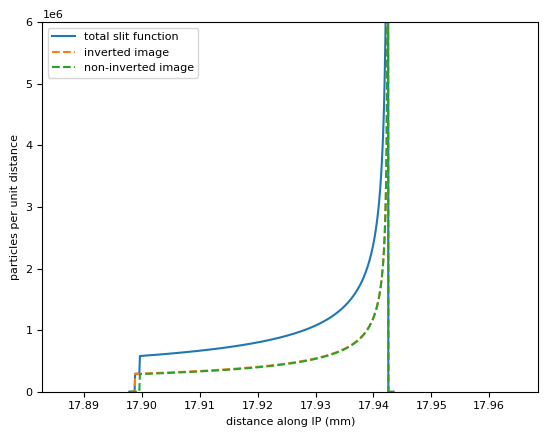

In [5]:
#>>initializing MagSpec

#Field from Gennady
NEPPS_Field = (88.6/79)*np.loadtxt('Magnetic_Field_NEPPS.txt', skiprows=1)

Baxes, Bdata = NEPPS_Field[:,0], NEPPS_Field[:,1]

Spec = MagSpec()

Spec.mag_field(Baxes,Bdata)

Spec.fineadjustment(fine_adjustment = 8)

#>>end of initialization for MagSpec

#>>Code for plotting particle trajectories

#Spec.plotIP(figsize = [16,16])

#various energies to test
#Energy = 10000
Energy = 5260
#Energy = 5000
#Energy = 5500
#Energy = 2000
#Energy = 150

IP_dist_val, X_data, Y_data, Z_data = Spec.track_1D_slit(
    plotting = False,
    Energy_eV = Energy,
    source = 'point',
    Range = np.linspace(-0.002,0.002,51), 
    theta_z = 0,
    theta_0 = 0)

#zoom in!
xc = 0.015
yc = 0.014
w = 0.005
#plt.xlim(xc-w,xc+w)
#plt.ylim(yc-w,yc+w)
#print(Spec.TCC_x)

#better view of tracks
#plt.xlim(-0.005,0.030)
#plt.ylim(-0.005,0.030)
#plt.xlabel('x position (m)')
#plt.ylabel('y position (m)')
#SMALL_SIZE = 10
#MEDIUM_SIZE = 12
#BIGGER_SIZE = 15
#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
#plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
#plt.legend()

#>>end of code for plotting particle trajectories

#>>code for plotting slit function

IP_linspace, Particle_Density, Particle_Density_a, Particle_Density_b = Spec.slit_function_precise(IP_dist_val)
plt.plot(IP_linspace*1000, Particle_Density, label = 'total slit function')
#print(Particle_Density)
#print(IP_linspace)
plt.plot(IP_linspace*1000, Particle_Density_a, linestyle = '--', label = 'inverted image')
plt.plot(IP_linspace*1000, Particle_Density_b, linestyle = '--', label = 'non-inverted image')
plt.xlim(1000*IP_linspace[0]-0.015,1000*IP_linspace[-1]+0.025)
plt.ylim(0,0.2e6)
plt.ylim(0,0.6e7)
plt.rc('font',size=8)
plt.legend()
plt.xlabel('distance along IP (mm)')
plt.ylabel('particles per unit distance')

#>>end of code for plotting slit function

#>>plotting x(E) and dxdE

#fig, ax1 = plt.subplots(figsize = [5,5])
#plt.rc('font', size=15)
#ax2 = ax1.twinx()
#Espace = np.append(np.linspace(140.97,140.97+1500,501),np.linspace(140.97+2000,10e6+140.97,2001))
#Xspace = Spec.EXdispersion(Espace)
#np.savetxt("Generated_Dispersion.txt", np.array([(1/1000)*Espace,1000*Xspace]), delimiter=",")
#ax1.plot((1/1000)*Espace,1000*Xspace, label = 'x(E)')

#compare to Gennady's data
#energy_data_protons = np.loadtxt('NEPPS_Dispersion_Protons_087T.txt', skiprows=1)
#plt.plot(energy_data_protons[:,0],energy_data_protons[:,1])
#plt.plot(Espace,Xspace-(1/1000)*energy_data_protons[:,1])

#ax1.set_xlabel("Energy (keV)")
# ax1.set_ylabel("Distance Traveled Along IP (mm)")
# plt.title("x(E) Dispersion Relation at Normal Incidence")
# dxdE = np.gradient(1000*Xspace,(1/1000)*Espace)
# ax2.plot((1/1000)*Espace,dxdE,label = 'dx/dE',color = 'red')
# ax2.set_ylabel('change in distance per change in energy (mm/keV)')

# ax1.tick_params(axis = 'y', labelcolor = 'blue')
# ax2.tick_params(labelcolor = 'red')

# ax1.legend(bbox_to_anchor = (0.95,0.85), loc = 'right')
# ax2.legend(bbox_to_anchor = (0.95,0.15), loc = 'right')
# end of plotting e and dxdE


#plt.xlim(-0.5,-0.49)
#plt.ylim(-0.005,0.005)

#for slit function
#plt.xlim(0.0175,0.0177)
#plt.ylim(0,1e7)
#plt.xlabel("Position Along IP (m)")
#plt.ylabel("Particle Density (dN/dx)")
#plt.title("Slit Function at Energy " + str(Energy) + "eV")
#plt.legend()

In [50]:
NEPPS_Field = (88.6/79)*np.loadtxt('Magnetic_Field_NEPPS.txt', skiprows=1)
Baxes, Bdata = NEPPS_Field[:,0], NEPPS_Field[:,1]
Spec = MagSpec()
Spec.mag_field(Baxes,Bdata)
Spec.fineadjustment(fine_adjustment = 8)

x_space, plot_data_axes, slit_function_data, IP_data = Spec.varying_slit_function(
        resolution = 0.0001,
        E_space = np.linspace(1000,500000,500),
        source = 'point',
        Range = np.linspace(-0.002,0.002,51),
        theta_0 = 0,
        theta_z = 0,
        precise = True)

Spectrometer Initialized!


559


Text(0, 0.5, 'Particles per meter (dn/dE)')

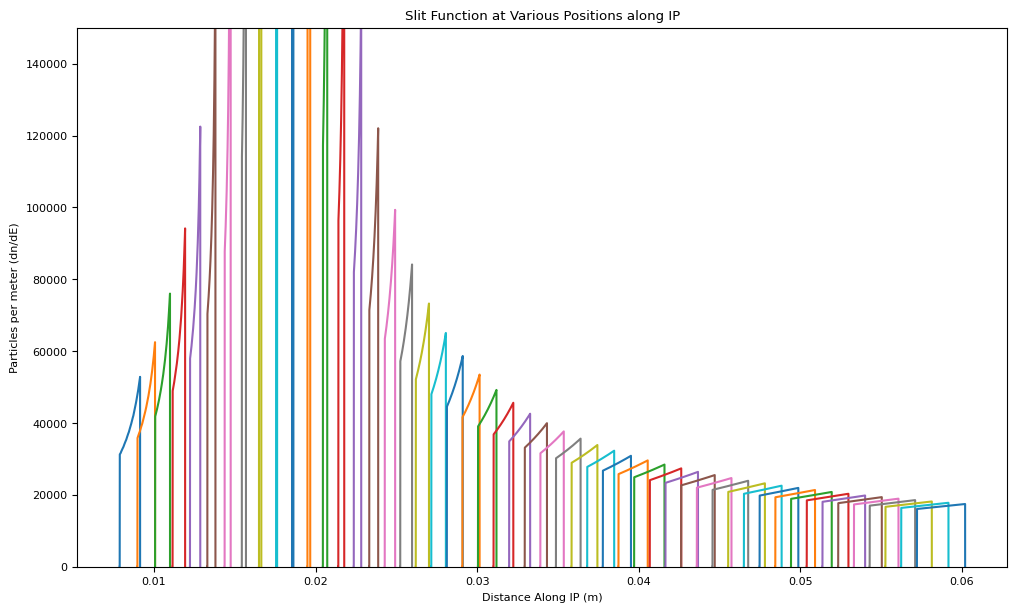

In [67]:
plt.figure(figsize=[12,7])

print(len(x_space))
for i in np.linspace(0,500,51).astype(int):
    plt.plot(plot_data_axes[i],slit_function_data[i])

#plt.ylim(2e7,4.7e7)
plt.ylim(0,1.5e5)
c = 0.018
w = 0.003
plt.title("Slit Function at Various Positions along IP")
plt.xlabel("Distance Along IP (m)")
plt.ylabel("Particles per meter (dn/dE)")
#plt.xlim(c-w,c+w)

In [1]:
def linear_particle_density(IP_dist_val):
    max = np.max(IP_dist_val)
    for i in range(len(IP_dist_val)):
        if IP_dist_val[i] == max:
            max_index = i
    print('Particle index with maximum displacement:', max_index)
    print('Final particle index:', len(IP_dist_val)-1)
    print('Normal incidence IP position:', IP_dist_val[int(0.5*len(IP_dist_val))])

    if max_index == 0:
        interpart_dist_a = np.zeros(len(IP_dist_val))
        interpart_dist_a[0] = 2*(np.abs(IP_dist_val[1]-IP_dist_val[0]))
        interpart_dist_a[-1] = 2*(np.abs(IP_dist_val[-1]-IP_dist_val[-2]))
        
        for i in range(len(IP_dist_val)-2):
            interpart_dist_a[i+1] = np.abs(IP_dist_val[i+2]-IP_dist_val[i+1])+np.abs(IP_dist_val[i+1]-IP_dist_val[i+0])
        
        IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
        interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_val), np.flip(interpart_dist_a), left=1e7, right=1e7)

        Particle_Density_a = 1/interp_interpart_a
        Particle_Density_b = 0*IP_linspace
        Particle_Density = 1/interp_interpart_a
    elif 2 < max_index < ((len(IP_dist_val))-3):

        IP_dist_a = IP_dist_val[:max_index+1]
        IP_dist_b = IP_dist_val[max_index+1:]

        interpart_dist_a = np.zeros(len(IP_dist_a))
        interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
        interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
        for i in range(len(IP_dist_a)-2):
            interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

        interpart_dist_b = np.zeros(len(IP_dist_b))
        interpart_dist_b[0] = 2*(np.abs(IP_dist_b[1]-IP_dist_b[0]))
        interpart_dist_b[-1] = 2*(np.abs(IP_dist_b[-1]-IP_dist_b[-2]))
        for i in range(len(IP_dist_b)-2):
            interpart_dist_b[i+1] = np.abs(IP_dist_b[i+2]-IP_dist_b[i+1])+np.abs(IP_dist_b[i+1]-IP_dist_b[i+0])

        IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
        interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
        interp_interpart_b = np.interp(IP_linspace, np.flip(IP_dist_b), np.flip(interpart_dist_b), left=1e7, right=1e7)

        Particle_Density_a = 1/interp_interpart_a
        Particle_Density_b = 1/interp_interpart_b
        Particle_Density = 1/interp_interpart_a + 1/interp_interpart_b
    elif max_index < 3:
        IP_dist_a = IP_dist_val[max_index:]
        
        interpart_dist_a = np.zeros(len(IP_dist_a))
        interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
        interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
        for i in range(len(IP_dist_a)-2):
            interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

        IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
        interp_interpart_a = np.interp(IP_linspace, np.flip(IP_dist_a), np.flip(interpart_dist_a), left=1e7, right=1e7)
        
        Particle_Density_a = 1/interp_interpart_a
        Particle_Density_b = 0*IP_linspace
        Particle_Density = 1/interp_interpart_a
    else:
        IP_dist_a = IP_dist_val[:max_index+1]
        
        interpart_dist_a = np.zeros(len(IP_dist_a))
        interpart_dist_a[0] = 2*(np.abs(IP_dist_a[1]-IP_dist_a[0]))
        interpart_dist_a[-1] = 2*(np.abs(IP_dist_a[-1]-IP_dist_a[-2]))
        for i in range(len(IP_dist_a)-2):
            interpart_dist_a[i+1] = np.abs(IP_dist_a[i+2]-IP_dist_a[i+1])+np.abs(IP_dist_a[i+1]-IP_dist_a[i+0])

        IP_linspace = np.linspace(np.min(IP_dist_val)-0.0005,np.max(IP_dist_val)+0.0005,5000)
        interp_interpart_a = np.interp(IP_linspace, IP_dist_a, interpart_dist_a, left=1e7, right=1e7)
        
        Particle_Density_a = 1/interp_interpart_a
        Particle_Density_b = 0*IP_linspace
        Particle_Density = 1/interp_interpart_a
    return IP_linspace, Particle_Density, Particle_Density_a, Particle_Density_b


#example use of this function!
IP_linspace, Particle_Density, Particle_Density_a, Particle_Density_b = linear_particle_density(IP_dist_val)

plt.plot(IP_linspace, Particle_Density)
plt.plot(IP_linspace, Particle_Density_a)
plt.plot(IP_linspace, Particle_Density_b)

#plt.xlim(np.min(IP_dist_b)-0.0001,np.max(IP_dist_b)+0.0001)

NameError: name 'IP_dist_val' is not defined

In [ ]:
#this is a plot of IP position vs theta
#starting with negative theta (bottom of slit) to positive theta (top of slit)
theta_fine = np.linspace(thetarange[0],thetarange[-1],100)
fine_dist_val = np.interp(theta_fine, thetarange, IP_dist_val)
plt.plot(theta_fine,fine_dist_val)
max = np.max(fine_dist_val)
for i in range(len(fine_dist_val)):
    if fine_dist_val[i] == max:
        max_index = i
print(max_index)
print(max)
print(theta_fine[max_index])
plt.scatter(theta_fine[max_index],max)



In [ ]:
#Test Field
Baxes = np.linspace(0,0.5,100)
#Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.05)))
Bdata = 0.9*0.5*(1+np.tanh(40*(Baxes-0.030)))

IPradius = 0.14102
IPcenter = np.array([0.0450215,-0.12394])
Gapx = 0.0127
Gapy = 0.003302

E = 10000

solidangle = 0.001
N_particles = 51
thetarange = math.pi*np.linspace(-solidangle,solidangle,N_particles)

#Field from Gennady
NEPPS_Field = (89/79)*np.loadtxt('Magnetic_Field_NEPPS.txt', skiprows=1)
#print(NEPPS_Field)
B_Field_Max = np.max(NEPPS_Field[:,1])
print(B_Field_Max)
#plt.plot(NEPPS_Field[:,0],NEPPS_Field[:,1])

Baxes, Bdata = NEPPS_Field[:,0], NEPPS_Field[:,1]
plt.plot(Baxes,Bdata)

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))

def init_circ_slit(dtcc, r, deltatheta):
    m_max = math.floor((1/deltatheta)*math.atan(r/dtcc))
    m_min = -m_max
    #m is the y index; n is the z index
    mspace = np.linspace(m_min,m_max,m_max-m_min+1)
    narray = []
    for m in mspace:
        y_m = dtcc*math.tan(m*deltatheta)
        if abs(y_m) > r:
            y_m = (y_m/abs(y_m))*(abs(y_m)-(1e-15))
        z_max = np.sqrt((r**2)-(y_m**2))
        n_max = math.floor((1/deltatheta)*math.atan(z_max*math.cos(m*deltatheta)/dtcc))
        n_min = -n_max
        nspace = np.linspace(n_min,n_max,n_max-n_min+1)
        narray.append(nspace)
    return narray, m_min, m_max

def init_circ_boundary(dtcc, r, deltatheta):
    theta_axis = math.atan(r/dtcc)
    #here we use the LOS as the 'z' axis
    #thet_axis describes the angle from the z axis
    #now we initialize the range of theta values in the x-y plane
    thetarange = np.linspace(0,2*math.pi,int(2*math.pi/deltatheta)+1)
    i = 0
    #from here we change back to the LOS as the x-axis, to match with the other codes
    vy = np.zeros(len(thetarange))
    vz = np.zeros(len(thetarange))
    while i < len(thetarange):
        vy[i] = math.sin(theta_axis)*math.cos(thetarange[i])
        vz[i] = math.sin(theta_axis)*math.sin(thetarange[i])
        i = i+1
    vx = math.cos(theta_axis)
    return vx, vy, vz

def track_2D_slit(
    dtcc = 0.5,
    r = 0.002,
    deltatheta = (1/64)*0.0050*math.pi,
    Energy_eV = 10000,
    B_data = np.array([1]),
    B_axes = np.array([0]),
    delta_d = 0.000025,
    nonuniform_B = True,
    uniform_B = 1,
    charge_mass_ratio = 9.58e7,
    charge_in_e = 1,
    gapx = 0,
    gapy = 0,
    plate = 'curved',
    IP_radius = 0.14102,
    IP_center = np.array([0.0450215,-0.12394]),
    x_max = 1,
    y_max = 1,
    dynamic_step = 1,
    fine_adjustment = 8
    ):

    N, m_min, m_max = init_circ_slit(dtcc, r, deltatheta)
    min_n = np.zeros(m_max-m_min+1)
    max_n = np.zeros(m_max-m_min+1)

    #find the global maximum and minimum for n
    for i in range(m_max-m_min+1):
        min_n[i] = np.min(N[i])
        max_n[i] = np.max(N[i])
    len_m = int(m_max-m_min+1)
    MIN_N = np.min(min_n)
    MAX_N = np.max(max_n)
    len_n = int(MAX_N-MIN_N+1)

    print('len_n =',len_n)
    print('len_m =',len_m)

    target_array_y = np.zeros((len_n+2,len_m+2))
    target_array_z = np.zeros((len_n+2,len_m+2))
    cosine_adj = np.zeros((len_n+2,len_m+2))

    IP_array_r = np.zeros((len_n+2,len_m+2))
    IP_array_z = np.zeros((len_n+2,len_m+2))
    IP_array_true = np.zeros((len_n+2,len_m+2))

    print('target array shape =',np.shape(target_array_y))

    #vx,vy,vz = init_circ_boundary(dtcc, r, 10*deltatheta)

    #loop for going through each particle
    i = 0
    n_part = 0
    while i <= (m_max-m_min):
        n_min = np.min(N[i])
        for j in range(0,len(N[i])):
            n = int(N[i][j])
            m = int(i+m_min)
            #m is the y index; n is the z index
            #for k we must find the bottom of each n-list to adjust the indices
            #MIN_N is the global minimum n value in the whole N array
            #we need to ajust the bottom index for each N[i] to ensure that n=0 is at the same k-index for all data points
            k = int(j+(n_min-MIN_N))
            target_array_z[k+1,i+1] = dtcc*math.tan(n*deltatheta)*(1/math.cos(m*deltatheta))
            target_array_y[k+1,i+1] = dtcc*math.tan(m*deltatheta)
            cosine_adj[k+1,i+1] = math.cos(n*deltatheta)

            theta_0 = m*deltatheta
            theta_z = n*deltatheta

            y_0 = dtcc*math.sin(theta_0)*math.cos(theta_z)
            z_0 = dtcc*math.sin(theta_z)

            X, Y, Z = track_particle_2D(
                Energy_eV = Energy_eV,
                B_data = B_data,
                B_axes = B_axes,
                theta_0 = theta_0,
                theta_z = theta_z,
                y_0 = y_0,
                z_0 = z_0,
                delta_d = delta_d,
                nonuniform_B = nonuniform_B,
                uniform_B = uniform_B,
                charge_mass_ratio = charge_mass_ratio,
                charge_in_e = charge_in_e,
                gapx = gapx,
                gapy = gapy,
                plate = plate,
                IP_radius = IP_radius,
                IP_center = IP_center,
                x_max = x_max,
                y_max = y_max,
                dynamic_step = dynamic_step,
                fine_adjustment = fine_adjustment
                )
            #plt.plot(X,Y)

            X_end = X[-1]
            Y_end = Y[-1]

            XIP = X_end-IPcenter[0]
            YIP = Y_end-IPcenter[1]
            theta_0_IP = -math.pi + math.atan(np.sqrt(IPradius**2-(IPcenter[0])**2)/IPcenter[0])
            Xprime = math.cos(theta_0_IP)*XIP-math.sin(theta_0_IP)*YIP
            Yprime = math.sin(theta_0_IP)*XIP+math.cos(theta_0_IP)*YIP
            theta_IP_prime = -math.atan(Yprime/Xprime)
            IP_dist = theta_IP_prime*IPradius

            IP_array_r[k+1,i+1] = IP_dist
            IP_array_z[k+1,i+1] = Z[-1]
            IP_array_true[k+1,i+1] = 1

            n_part = n_part+1
        i = i+1

    print('number of particles =',n_part)
    return IP_array_r, IP_array_z, IP_array_true, target_array_z, target_array_y, cosine_adj


#Running the above functions!
dtcc = 0.5
r = 0.002
deltatheta = (1/64)*0.0050*math.pi

IP_array_r, IP_array_z, IP_array_true, target_array_z, target_array_y, cosine_adj = track_2D_slit(
    dtcc = dtcc,
    r = r,
    deltatheta = deltatheta,
    Energy_eV = 10000,
    B_data = Bdata,
    B_axes = Baxes,
    delta_d = 0.000025,
    nonuniform_B = True,
    uniform_B = 1,
    charge_mass_ratio = 9.58e7,
    charge_in_e = 1,
    gapx = Gapx,
    gapy = Gapy,
    plate = 'curved',
    IP_radius = 0.14102,
    IP_center = np.array([0.0450215,-0.12394]),
    x_max = 1,
    y_max = 1,
    dynamic_step = 1,
    fine_adjustment = 8
    )

plt.scatter(target_array_z,target_array_y)
plt.ylim(-r,r)
plt.xlim(-r,r)

x = np.linspace(-r,r,201)
plt.plot(x,np.sqrt((r**2)-(x**2)))
plt.plot(x,-np.sqrt((r**2)-(x**2)))

scale = np.sqrt((dtcc**2)+(r**2))/r

#plt.scatter(scale*vz,scale*vy)
#print(vy)
#print(vz)

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(IP_array_z,IP_array_r)
rmax = np.max(IP_array_r)
zmax = np.max(IP_array_z)
plt.xlim(-zmax-0.001,zmax+0.001)
plt.ylim(rmax-2*zmax,rmax+0.002)
plt.ylim(rmax-0.5*zmax,rmax+0.0001)

In [ ]:
#loop for finding the area occupied by each particle
area_density_function = 0*IP_array_true

i = 0
j = 0
for i in range(0,np.shape(IP_array_r)[1]):
    for j in range(0,np.shape(IP_array_r)[0]):
        #j is z
        #i is y
        #FIRST INDEX in [j,i] is z
        #SECOND INDEX in [j,i] is r
        #indices are used differently later but keep as reference

        if IP_array_true[j,i] == 1:
            deltay1 = IP_array_r[j,i+1]-IP_array_r[j,i]
            deltaz1 = IP_array_z[j,i+1]-IP_array_z[j,i]
            deltar1 = [deltaz1,deltay1]

            deltay2 = IP_array_r[j+1,i]-IP_array_r[j,i]
            deltaz2 = IP_array_z[j+1,i]-IP_array_z[j,i]
            deltar2 = [deltaz2,deltay2]

            deltay3 = IP_array_r[j,i-1]-IP_array_r[j,i]
            deltaz3 = IP_array_z[j,i-1]-IP_array_z[j,i]
            deltar3 = [deltaz3,deltay3]

            deltay4 = IP_array_r[j-1,i]-IP_array_r[j,i]
            deltaz4 = IP_array_z[j-1,i]-IP_array_z[j,i]
            deltar4 = [deltaz4,deltay4]
            
            scale1 = IP_array_true[j,i+1]*IP_array_true[j+1,i]
            scale2 = IP_array_true[j+1,i]*IP_array_true[j,i-1]
            scale3 = IP_array_true[j,i-1]*IP_array_true[j-1,i]
            scale4 = IP_array_true[j-1,i]*IP_array_true[j,i+1]

            area1 = scale1*np.abs(np.cross(deltar1,deltar2))
            area2 = scale2*np.abs(np.cross(deltar2,deltar3))
            area3 = scale3*np.abs(np.cross(deltar3,deltar4))
            area4 = scale4*np.abs(np.cross(deltar4,deltar1))

            area = 2*(area1+area2+area3+area4)
            scale = scale1+scale2+scale3+scale4

            if area == 0:
                area = 1

            area_density_function[j,i] = scale/area
            if scale == 0:
                area_density_function[j,i] = np.nan
        else:
            area_density_function[j,i] = np.nan

        j = j+1
    i = i+1


#plt.imshow((target_array_true))
#plt.imshow((area_density_function))

#print(IP_array_r[int(0.5*np.shape(IP_array_r)[0]),int(0.5*np.shape(IP_array_r)[1])])
#print(IP_array_z[int(0.5*np.shape(IP_array_r)[0]),int(0.5*np.shape(IP_array_r)[1])])
#print(area_density_function[int(0.5*np.shape(IP_array_r)[0]),int(0.5*np.shape(IP_array_r)[1])])

#assigning z, r, and f(z,r) values to 1d arrays
IP_z = []
IP_r = []
area_density = []

for i in range(np.shape(IP_array_r)[0]):
    for j in range(np.shape(IP_array_r)[1]):
        if area_density_function[i,j] != np.nan and area_density_function[i,j] != 0 and IP_array_true[i,j] != 0:
            area_density.append(area_density_function[i,j])
            IP_z.append(IP_array_z[i,j])
            IP_r.append(IP_array_r[i,j])

IP_z = np.array(IP_z)
IP_r = np.array(IP_r)
area_density = np.array(area_density)

#mid = int(0.5*np.shape(IP_array_r)[0])
#plt.imshow(IP_array_z[mid-15:mid+15,mid-15:mid+15])
#print(IP_array_z[mid,mid])
#plt.colorbar()

#contour color plot
contourf_ = plt.figure(figsize = (7,6))
adf_norm = area_density_function[int(0.5*np.shape(IP_array_r)[0]),int(0.5*np.shape(IP_array_r)[1])]
contourf_ = plt.contourf(IP_array_z, IP_array_r, area_density_function, np.linspace(0.7e8,2.6*adf_norm,50), cmap='viridis')
plt.colorbar(contourf_)
plt.xlim(-zmax-0.001,zmax+0.001)
plt.ylim(rmax-2*zmax,rmax+0.002)
#plt.ylim(rmax-0.5*zmax,rmax+0.0001)

#surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(IP_array_z, IP_array_r, area_density_function, cmap='viridis') # 'viridis' is a colormap
ax.set_xlim(-zmax,zmax)
ax.set_ylim(rmax-0.001,rmax)
plt.show()

In [ ]:
from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
z_val = IP_z
r_val = IP_r
zippedzr = zip(z_val,r_val)
interp = LinearNDInterpolator(list(zippedzr), area_density, fill_value=np.nan, rescale=False)

Z = np.linspace(np.min(z_val), np.max(z_val), 100)
R = np.linspace(1.5*np.min(r_val)-0.5*np.max(r_val), 1.5*np.max(r_val)-0.5*np.min(r_val), 200)
Z, R = np.meshgrid(Z, R)
area_interp = interp(Z, R)
plt.pcolormesh(Z, R, area_interp, shading='auto')
#plt.plot(z_val, r_val, "ok", label="input point")
plt.colorbar()
plt.axis("equal")

#surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, R, area_interp, cmap='viridis') # 'viridis' is a colormap

print(np.min(area_interp))
plt.show()

In [ ]:
NEPPS_Field = (89/79)*np.loadtxt('Magnetic_Field_NEPPS.txt', skiprows=1)
#print(NEPPS_Field)
B_Field_Max = np.max(NEPPS_Field[:,1])
print(B_Field_Max)
plt.plot(NEPPS_Field[:,0],NEPPS_Field[:,1])

coefficients = np.polyfit(np.array([-0.01, -0.0085, -0.007, -0.0065, -0.005, 0.00010908841522462055, 0.000545452063694404, 0.0011272680421938273]), np.array([0, 0.0003, 0.0009, 0.0027, 0.0081, 0.16281, 0.184504132, 0.2145]), 5)

x = np.linspace(-0.01,0.0012,20)

poly_fit_B = np.poly1d(coefficients)
plt.plot(x,poly_fit_B(x))
print(x[-12:-9])
print(poly_fit_B(x)[-12:-9])

In [ ]:
#EXAMPLE CODE FOR 2D INTERP

from scipy.interpolate import LinearNDInterpolator
import numpy as np
import matplotlib.pyplot as plt
x_val = [1,3,5,7,8,9,4,7,6]
y_val = [1,5,4,6,7,9,8,2,4]
zippedxy = zip(x_val,y_val)
z_val = [1,7,3,9,5,6,7,8,1]
interp = LinearNDInterpolator(list(zippedxy), z_val, fill_value=np.nan, rescale=False)
X = np.linspace(np.min(x_val), np.max(x_val))
Y = np.linspace(np.min(y_val), np.max(y_val))
X, Y = np.meshgrid(X, Y)
Z = interp(X, Y)
plt.pcolormesh(X, Y, Z, shading='auto')
plt.plot(x_val, y_val, "ok", label="input point")
plt.legend()
plt.colorbar()
plt.axis("equal")
plt.show()